In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def show_images(images, titles = None):
    """Method to plot the images array. The images is the array of images array"""
    images_count = len(images) * len(images[0])
    index = 1;
    cols = len(images)
    if images_count < cols:
        cols = images_count
    rows = images_count//cols
    if rows == 0:
        rows = 1
    if rows * cols < images_count:
        rows += 1
    print('images_count: {}, rows: {}, cols: {}'.format(images_count, rows, cols))
    figsize = (8 * cols, 5 * rows)
    fontsize = cols * 10
    fig = plt.figure(figsize=figsize)
    
    for image_index in range(len(images[0])):
        for array_index in range(len(images)):
            ax = fig.add_subplot(rows, cols, index)
            if titles is not None:
                ax.set_title(titles[array_index], fontsize = fontsize)
                plt.imshow(images[array_index][image_index], cmap = 'gray')
            index += 1
    plt.tight_layout()
    plt.show()
    
def show_channel_images(images, cols = 2, titles = None):
    """Method to show the channel images"""
    images_count = len(images)
    index = 1;
    if images_count < cols:
        cols = images_count
    rows = images_count//cols
    if rows == 0:
        rows = 1
    if rows * cols < images_count:
        rows += 1
    print('images_count: {}, rows: {}, cols: {}'.format(images_count, rows, cols))
    figsize = (8 * cols, 5 * rows)
    fontsize = cols * 10
    fig = plt.figure(figsize=figsize)
    
    for image_index in range(images_count):
        ax = fig.add_subplot(rows, cols, index)
        if titles is not None:
            ax.set_title(titles[image_index], fontsize = fontsize)
        plt.imshow(images[image_index], cmap='gray')
        index += 1
    plt.tight_layout()
    plt.show()

In [3]:
def get_objpoints_imagepoints(directory_path):
    """gets the object points and image points of the given gray image"""
    #Array to store object points and image points from all the images
    imgpoints = [] # 3D points in real world space
    objpoints = [] # 2D points in image plane

    #chess board initials
    cb_height = 6
    cb_width = 9
    cb_shape = (cb_width, cb_height)
    
     # prepare object points, like (0,0,0), (1,0,0), (2,0,0)...., (7,5,0)
    objp = np.zeros((cb_height*cb_width, 3), np.float32)
    objp[:,:2] = np.mgrid[0:cb_width,0:cb_height].T.reshape(-1,2) # x,y coordinates
    
    for path in glob.glob(directory_path):
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        # If corners are found, add object and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return objpoints, imgpoints
 
def get_images(path):
    """Get all images in RGB from the given directory"""
    images = []
    for path in glob.glob(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images
    
def undistort(image, objpoints, imgpoints):
    """calibrates and returns undistored RGB image on the given RGB image"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # mtx = camera matrices
    # dist = distortion coefficients
    # rvecs = rotation vector
    # tvecs = translation vector
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)


In [4]:
def get_binary(scaled, thresh):
    """return the binary image after threshold application"""
    binary = np.zeros_like(scaled)
    binary[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

def get_scaled(value):
    """Scale to 8-bit (0 - 255) then convert to type = np.uint8"""
    return np.uint8(255 * value/ np.max(value))

def get_sobel(image, orient='x', sobel_kernel = 3):
    """Pass only the single channel image"""
    if (len(image.shape) > 3):
        if (img.shape[2] > 1):
            raise ValueError('Expecting only single channel image')
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobel;

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Get the binary sobel binary for given orientation"""
    abs_sobel = np.absolute(get_sobel(image, orient, sobel_kernel))
    scaled_sobel = get_scaled(abs_sobel)
    return get_binary(scaled_sobel, thresh)

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    """Get the magnitude threshold binary"""
    sobelx = get_sobel(image, 'x', sobel_kernel)
    sobely = get_sobel(image, 'y', sobel_kernel)
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = get_scaled(mag)
    # Calculate gradient magnitude
    return get_binary(scaled_mag, thresh)

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Get the directional threshold binary"""
    abs_sobelx = np.absolute(get_sobel(image, 'x', sobel_kernel))
    abs_sobely = np.absolute(get_sobel(image, 'y', sobel_kernel))
    
    grad = np.arctan2(abs_sobely, abs_sobelx)
        
    return get_binary(grad, thresh)

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def saturation_thresh(img, thresh=(0, 255)):
    """Get the Saturation threshold value"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    return get_binary(s, thresh)

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def cr_thresh(img, thresh=(0, 255)):
    """Get the binary image after applying Cr threshold (YCbCr)"""
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    cr = ycrcb[:,:,1]
    return get_binary(cr, thresh)


In [215]:
def convert2binary(image):
    """Get the binaries image, it will contain the distinct lane lines as 1 and rest as 0"""
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    l = hls[:,:,1]

    s_binary = get_binary(s, thresh=(90, 255))
    l_binary = get_binary(l, thresh=(190, 255))
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=7, thresh=(20, 100))
    mag_thr = mag_thresh(gray, 9, (30, 100))
    dir_thr = dir_thresh(gray, 15, (.7, 1.3))
    
    
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    cr = ycrcb[:,:,1]    
    cr_binary = get_binary(cr, thresh=(145, 180))
        
#     # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[( (s_binary == 1) & (l_binary == 1)) |
                    ((gradx == 1) ) |
                    (cr_binary == 1) | 
                    ( (mag_thr == 1) & (dir_thr == 1) )] = 1
    
    return combined_binary

# Use color transforms, gradients, etc., to create a thresholded binary image.

def get_roi(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.array([vertices]), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_warped_image(image, src, dst):
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp an image using the perspective transform, M:
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

# Sliding window search

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),
           img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    """Get the left and right x values for hot pixels where the lane line is detected"""
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    leftx, rightx = [], []
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    leftx.append(l_center)
    rightx.append(r_center)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2

        # getting the mean of all left and right pixels so far
        leftx_mean = np.mean(leftx)
        rightx_mean = np.mean(rightx)
        
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_signal = np.argmax(conv_signal[l_min_index:l_max_index])
        
        if l_signal < 2: #not able to detect any hot pixel, so relying on mean
            l_center = leftx_mean
        else:
            l_center = l_signal + l_min_index - offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_signal = np.argmax(conv_signal[r_min_index:r_max_index])

        if r_signal < 2: #not able to detect any hot pixel, so relying on mean
            r_center = rightx_mean
        else:
            r_center = r_signal + r_min_index - offset
        
        # There are many frames where the convolve identifies wrong hot pixels. Checking mean and correcting any big deviation
        if np.absolute(l_center - leftx_mean) > window_width * 2:
            l_center = leftx_mean + (l_center - leftx_mean) * .7
        if np.absolute(r_center - rightx_mean) > window_width * 2:
            r_center = rightx_mean + (r_center - rightx_mean) * .7
        
        leftx.append(l_center)
        rightx.append(r_center)
    return list(zip(leftx, rightx))

def find_lanes(image, window_width, window_height, margin):
    """Finds the lanes and returns the output image with left and right points array"""
    window_centroids = find_window_centroids(image, window_width, window_height, margin)
    left, right = None, None
#     print('window_centroids', window_centroids)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows 	
        for level in range(0, len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width, window_height, image, window_centroids[level][0], level)
            r_mask = window_mask(window_width, window_height, image, window_centroids[level][1], level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
        lefts = l_points.nonzero()
        rights = r_points.nonzero()
        # Draw the results
        template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) # make window pixels green
        warpage= np.dstack((image, image, image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    return output, lefts, rights

def draw_polyfit(undist, binary_warped, lefts, rights, Minv, avgPolyFit):
    # Fit a second order polynomial to each
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ylength = binary_warped.shape[0]
    ploty = np.linspace(0, ylength-1, ylength )
    
#     print('len lefts[0]: {}, len lefts[1]: {}'.format(len(lefts[0]), len(lefts[1])))
    #Add current polyfit to average and then get the average to be used here
    avgPolyFit.addLeft(np.polyfit(lefts[0], lefts[1], 2))
    left_fit = avgPolyFit.getAvgLeft()
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    #Add current polyfit to average and then get the average to be used here
    avgPolyFit.addRight(np.polyfit(rights[0], rights[1], 2))
    right_fit = avgPolyFit.getAvgRight()
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    
    region_pts = np.hstack((left_line_window, right_line_window))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([region_pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    car_center = binary_warped.shape[1]/2
    left_bottom = left_fit[0]*ylength**2 + left_fit[1]*ylength + left_fit[2]
    right_bottom = right_fit[0]*ylength**2 + right_fit[1]*ylength + right_fit[2]
    lane_center = (left_bottom + right_bottom) / 2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    car_deviation_from_center = (car_center - lane_center) * xm_per_pix
    
#     print('left bottom: {}, right bottom: {}, car_deviation: {}'.format(left_bottom, right_bottom, car_deviation_from_center))
    
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0), car_deviation_from_center

def cal_values(binary_warped, lefts, rights):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ylength = binary_warped.shape[0]
    ploty = np.linspace(0, ylength-1, ylength )
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Example values: 1926.74 1908.48
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefts[0]*ym_per_pix, lefts[1]*xm_per_pix, 2)
    
    right_fit_cr = np.polyfit(rights[0]*ym_per_pix, rights[1]*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curv = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curv = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curv, right_curv

def process_image(image):
    """Final pipeline for the processing of image of Finding Advanced Lane Lines"""
    global constant
    global Minv
    global images
    global avgPF
    if constant is None:
        constant = Constant(image.shape)
    undist = undistort(image, constant.OBJPOINTS, constant.IMGPOINTS)
    binary = convert2binary(undist)
    warped = get_warped_image(binary, constant.SRC, constant.DST)
    warped = get_roi(warped, constant.ROI)
    lanes, lefts, rights = find_lanes(warped, constant.WINDOW_WIDTH, constant.WINDOW_HEIGHT, constant.MARGIN)
    left_curv, right_curv = cal_values(image, lefts, rights)
    final, car_dev = draw_polyfit(undist, warped, lefts, rights, constant.Minv, avgPF)
    final = inset_image(lanes, final, left_offset = final.shape[1] - 300, resize_factor = .2, convert2RGB = False)
    avg_curv = (left_curv + right_curv)/2
    txt = 'Curve Radius: {:0.2f}m'.format(avg_curv)
    cv2.putText(final, txt, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    txt = 'Center: {:0.2f}m'.format(car_dev)
    cv2.putText(final, txt, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return final

def inset_image(resize_image, to_image, resize_factor = .2, left_offset = 20, convert2RGB = False):
    """insert the given resize_image to the to_image"""
    if convert2RGB:
        resize_image = np.array(cv2.merge((resize_image, resize_image, resize_image)),np.uint8)
    resize = cv2.resize(resize_image, None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_AREA)
    to_image[20: 20 + resize.shape[0], left_offset: left_offset + resize.shape[1]] = resize
    return to_image

class Constant:
    """Class which contains the constant values for the pipeline"""
    def __init__(self, shape):
        self.SHAPE = shape
        self.ROI_LEFT_PADDING = 400
        self.ROI_RIGHT_PADDING = 320
        self.PADDING = 410
        self.ROI =  np.array([
                            [self.ROI_LEFT_PADDING, 0],
                            [self.SHAPE[1] - self.ROI_RIGHT_PADDING, 0],
                            [self.SHAPE[1] - self.ROI_RIGHT_PADDING, self.SHAPE[0]], 
                            [self.ROI_LEFT_PADDING, self.SHAPE[0]]]
                            , dtype=np.int32)
        self.DST = np.float32([
                            [self.PADDING, 0],
                            [self.SHAPE[1] - self.PADDING, 0],
                            [self.PADDING, self.SHAPE[0]],
                            [self.SHAPE[1] - self.PADDING, self.SHAPE[0]] ])
        self.SRC = np.float32([ 
                            [self.SHAPE[1]*0.45, self.SHAPE[0]*0.63],
                            [self.SHAPE[1]*0.55, self.SHAPE[0]*0.63],
                            [self.SHAPE[1]*0.10, self.SHAPE[0]],
                            [self.SHAPE[1]*0.90, self.SHAPE[0]]])  
        self.WINDOW_WIDTH = 40 
        self.WINDOW_HEIGHT = 80 # Break image into 9 vertical layers since image height is 720
        self.MARGIN = 120 # How much to slide left and right for searching
        self.OBJPOINTS, self.IMGPOINTS = get_objpoints_imagepoints('camera_cal/*.jpg')
        self.Minv = cv2.getPerspectiveTransform(self.DST, self.SRC)
        
class Average:
    """store list by adding to item and return Average"""
    def __init__(self, period):
        self.total = 0
        self.queue = []
        self.period = period
    
    def append(self, item):
        """add item to the list"""
        #print("append item: ", item)
        self.total += item
        self.queue.append(item)
        #print("append total new ", self.total)
        if len(self.queue) > self.period:
            self.total -= self.queue.pop(0)
        
    def getAverage(self):
        """get the mean of the list"""
        length = len(self.queue)
        if length == 0:
            length = 1
        #print("get avg, total: ", self.total, ", queue length: ", len(self.queue), "mean: ", self.total/length)
        return self.total/length
    
    def clear(self):
        """clear the average"""
        self.total = 0
        self.queue.clear()
        
class AveragePolyFit:
    """calculate and store the average PolyFit for left and right poly fit"""
    
    def __init__(self, period):
        self.left = Average(period)
        self.right = Average(period)
        
    def clear(self):
        """clear all averages"""
        self.left.clear()
        self.right.clear()
    
    def addLeft(self, item):
        """add the left polyFit"""
        self.left.append(item)
    
    def getAvgLeft(self):
        """get the average left poly fit"""
        return self.left.getAverage()
    
    def addRight(self, item):
        """add the right polyFit"""
        self.right.append(item)
    
    def getAvgRight(self):
        """get the average right poly fit"""
        return self.right.getAverage()

        
print('compiled...')

compiled...


In [235]:
cam_images = get_images('camera_cal\*.jpg')
constant = None
avgPF = AveragePolyFit(1)
und_images = []
for image in cam_images[:1]:
    if constant is None:
        constant = Constant(image.shape)
    avgPF.clear()
    und_images.append(image)
    und_images.append(undistort(image, constant.OBJPOINTS, constant.IMGPOINTS))

images_count: 2, rows: 2, cols: 1


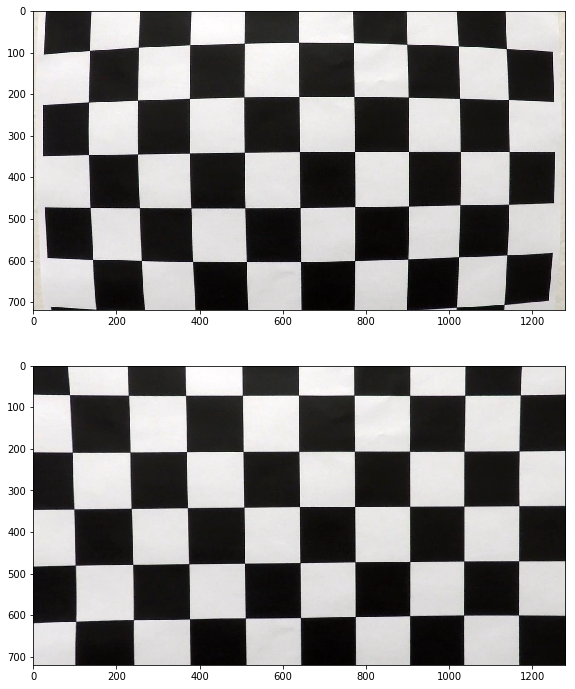

In [236]:
show_channel_images(und_images, cols = 1)

In [229]:
# Image pipeline

imgs = []
# constant = None

for image in raw_images[-1:]:
    avgPF.clear()
    global constant
    global Minv
    global images
    global avgPF
    if constant is None:
        constant = Constant(image.shape)
    imgs.append(image)
    undist = undistort(image, constant.OBJPOINTS, constant.IMGPOINTS)
    imgs.append(undist)
    binary = convert2binary(undist)
    imgs.append(binary)
    warped1 = get_warped_image(binary, constant.SRC, constant.DST)
    imgs.append(warped1)
    warped = get_roi(warped1, constant.ROI)
    imgs.append(warped)
    lanes, lefts, rights = find_lanes(warped, constant.WINDOW_WIDTH, constant.WINDOW_HEIGHT, constant.MARGIN)
    imgs.append(lanes)
    left_curv, right_curv = cal_values(image, lefts, rights)
    final, car_dev = draw_polyfit(undist, warped, lefts, rights, constant.Minv, avgPF)
    final = inset_image(lanes, final, left_offset = final.shape[1] - 300, resize_factor = .2, convert2RGB = False)
    avg_curv = (left_curv + right_curv)/2
    txt = 'Curve Radius: {:0.2f}m'.format(avg_curv)
    cv2.putText(final, txt, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    txt = 'Center: {:0.2f}m'.format(car_dev)
    cv2.putText(final, txt, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    imgs.append(final)


images_count: 7, rows: 7, cols: 1


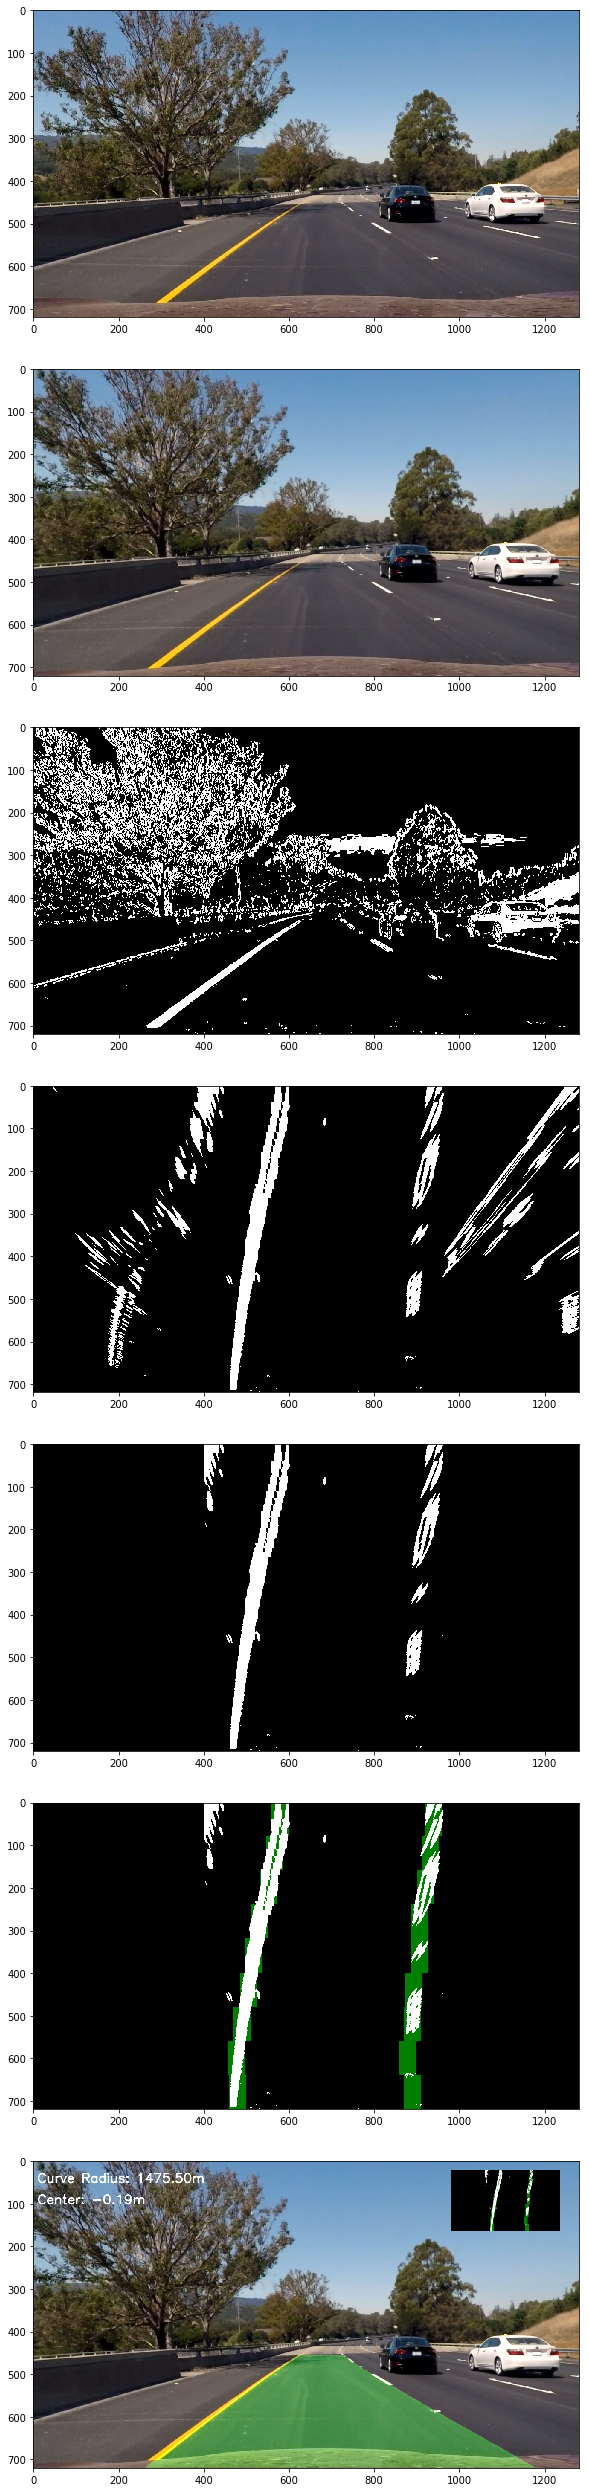

In [230]:
show_channel_images(imgs, cols = 1)

In [237]:
raw_images = get_images('test_images\*.jpg')
processed_images = []
constant = None
avgPF = AveragePolyFit(1)
for image in raw_images:
    avgPF.clear()
    processed_images.append(process_image(image))


images_count: 18, rows: 9, cols: 2


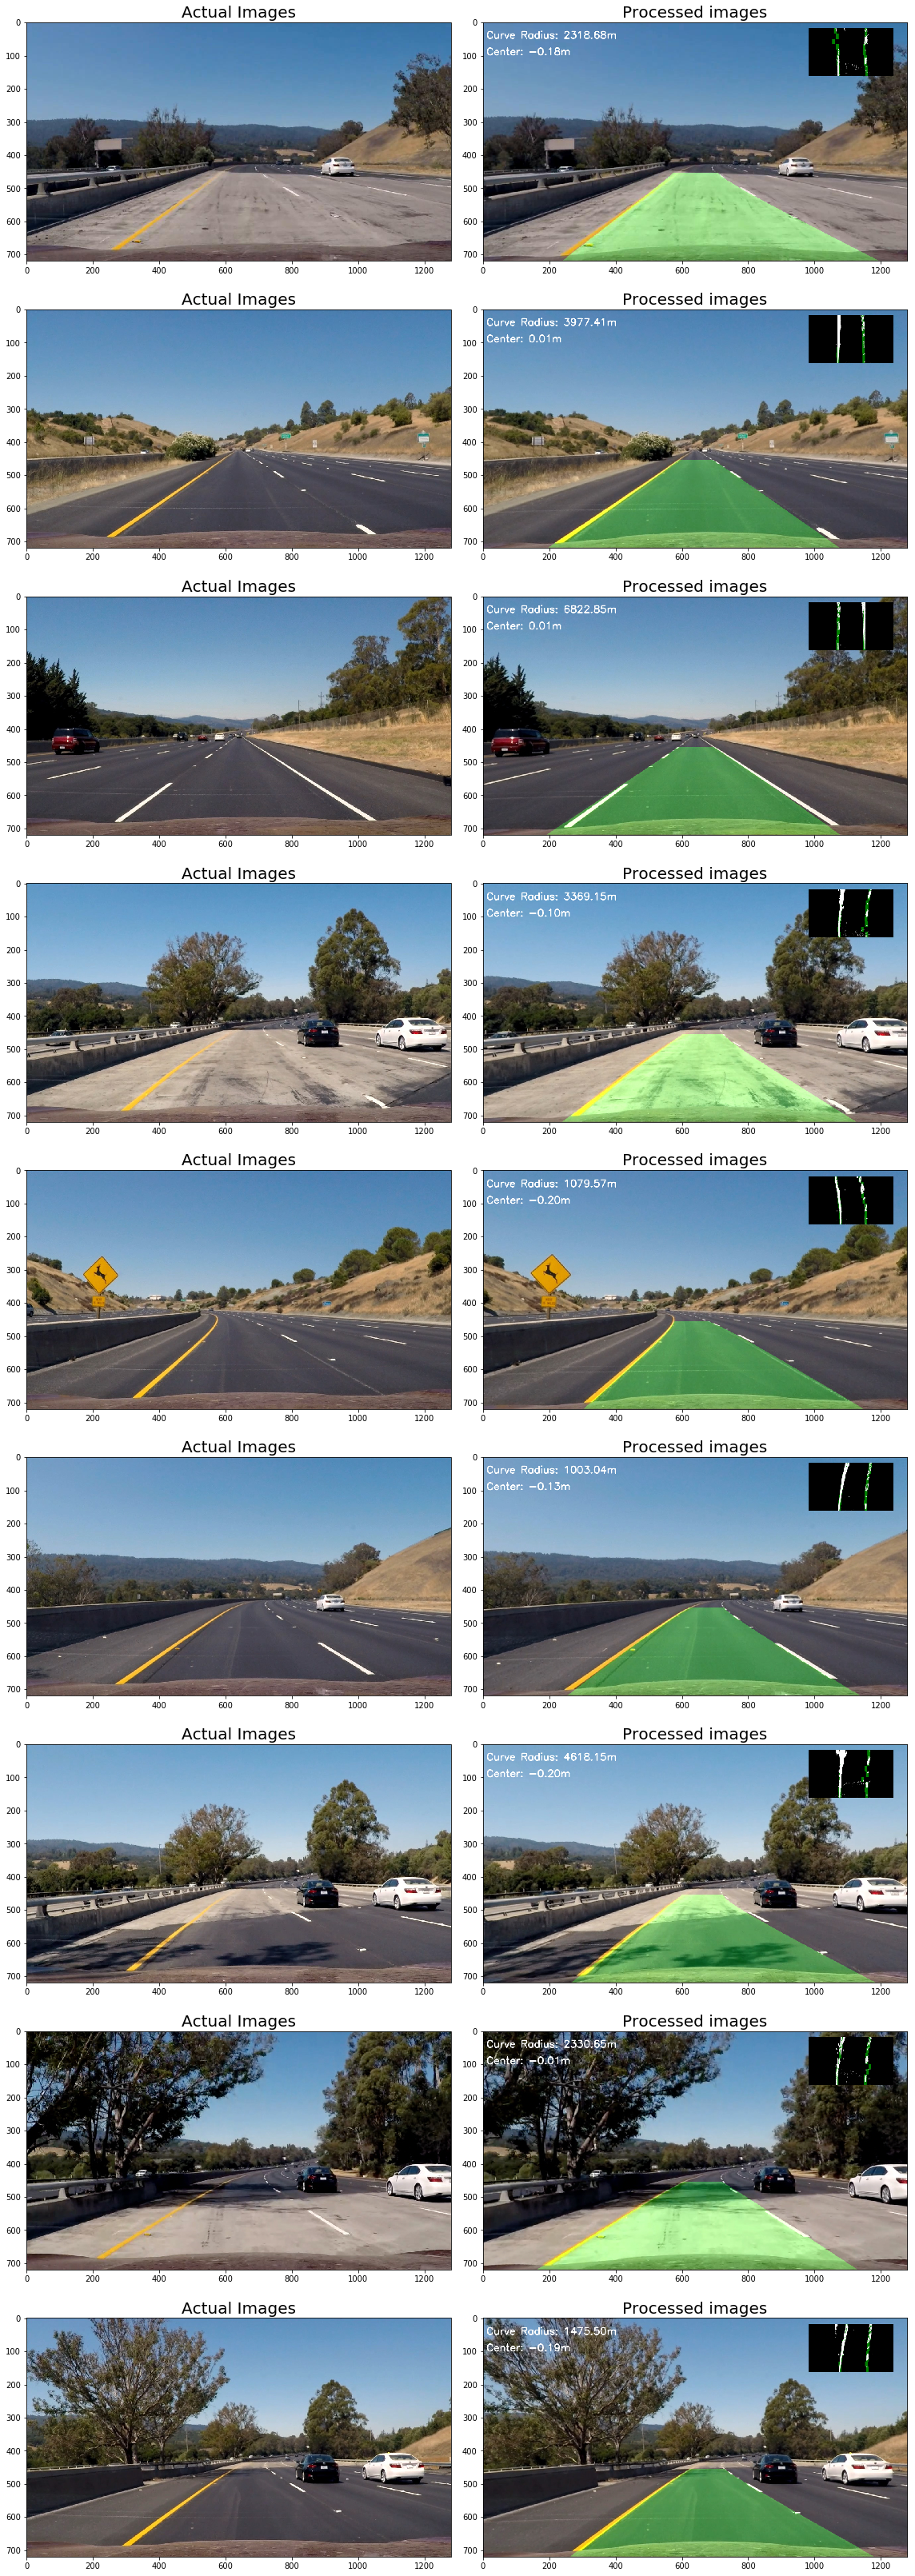

In [238]:
start = 0
end = len(raw_images)
show_images([raw_images[start:end], processed_images[start:end]], titles = ['Actual Images', 'Processed images'])

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
count = 1
# from IPython.display import HTML

In [212]:
video_output = 'output_project_video{}.mp4'.format(count)
count += 1
# avgPF = AveragePolyFit(20)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(21,25)
# clip1 = VideoFileClip("project_video.mp4")
avgPF = AveragePolyFit(12)
constant = None
processed_video = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)
processed_video.reader.close()
processed_video.audio.reader.close_proc()

[MoviePy] >>>> Building video output_project_video26.mp4
[MoviePy] Writing video output_project_video26.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:23<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video26.mp4 

Wall time: 22min 25s
